# Information Theory and Inference - Assignment 5

Gabriel Amorosetti - Matricola N. 2107530

In [1]:
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches

np.random.seed(2107530) # for reproducibility

# Assumed typos in the exercise : 
# - Part 1, Binomial PMF Formula : (1-p)^(N-x) instead of (1-p)^(1-x), and also X can be 0 as we use it later as inital value
# - Part 2, 3rd point : Xt ~ N (0, ¯Σ) instead of Xt ~ B(N, p)

---



## Part 1

Let $X \in \{0, 1,\ldots,N\}$ be a binomially-distributed variable with $N = 100$ and $p = 0.5$,
$$X \sim B(N,p)$$
with PMF (probability mass function)
$$P_X(x) = \binom{N}{x} p^x (1-p)^{N-x}$$

Sample this distribution with the Metropolis algorithm.



In [ ]:
# Parameters of our binomial distribution
N = 100
p = 0.5

# we define the associated probability mass function
def binomial_PMF(x, N, p):
    return comb(N, x)*(p**x)*((1-p)**(N-x))

# creating the target theoretical distribution 
x_val = np.arange(0, N+1)
target_distribution_1 = binomial_PMF(x_val, N, p)

- Use the following symmetric transition rule
$$
T(x',x) = \begin{cases}
1/2 & \text{if } x' = (x+1) \bmod N, \quad x \neq 0,N \\
1/2 & \text{if } x' = (x-1) \bmod N, \quad x \neq 0,N
\end{cases}
$$
such that $x$ transitions to $x \pm 1$ with equal probabilities (for $x = N$, $x + 1 \equiv 0$ and for $x = 0$, $x - 1 \equiv N$).


In [ ]:
# defining the symmetric transition rule T(x',x)

def proposal(x):
    N = 100
    a = np.random.rand() # return a random 1D sample in [0, 1) from the uniform distribution

    # we set x' = x - 1 or x + 1 with equal probabilities 
    # (taking a random 0-1 number and making the choice by separating the cases > or < to 1/2)
    if a < 0.5:
        xp = x + 1              # xp is x' 
    else:
        xp = x - 1

    # then we proceed to set x' (xp) or N, to N or 0, according to the rule when needed 
    if xp < 0:
        xp = N
    elif xp > N:
        xp = 0

    return xp

Combine the transition matrix (proposal) $T(x',x)$ with the Metropolis acceptance rule
$$A(x',x) = \min\left\{1, \frac{P_X(x')}{P_X(x)}\right\}$$
to define a Monte Carlo Markov Chain.

In [ ]:
def acceptance(x, xp, N, p):
    r = binomial_PMF(xp, N, p)/binomial_PMF(x, N, p) # computing the ratio 
    # if r >= 1 the new state is better
    # if r < 1  the new state is worse

    m = min(1, r)                                    # choosing the minimum between 1 and the ratio (in order to always have a proba not greater than 1)
    # if r >= 1, m = 1 
    # if r < 1,  m = r

    sample = np.random.rand() # random number in [0, 1) from the uniform distribution

    return sample < m # true we accept the new state, false we don't 

    # if r >= 1, m = 1, we always have sample < m, we return true (automatically accepted)
    # if r < 1,  m = r, we return true when sample < r, i.e. we accept the the new state with probability r


# the Monte Carlo Markov Chain using the symmetric transition rule and the acceptance rule defined previously :
def chain(x):

    # proposing the new state
    xp = proposal(x)

    # accepting the new state or keeping the previous one
    if acceptance(x, xp, N, p):
        return xp
    else: 
        return x


- Start from $X_0 = 0$ and let the Markov chain evolve, $X_t \rightarrow X_{t+1}$ up to $t = 10000$. Repeat this $M = 1000$ times, so that you have $M = 1000$ instances of the chain (for each value of $t$ you have $M = 1000$ values of $X_t$).



In [ ]:
# initial and final times
t0 = 0
tf = 10000

# number of instances of the chain
M = 1000

# list to store each of the instances
instances=[]

# letting the Markov chain evolve 1000 times
for i in range (0, M):

    X=[0] # current instance starting with the first state X0 = 0

    # each chain evolves from time t = 0 to t = 10000
    for t in range(0, tf):
        X.append(chain(X[t])) # adding the new state to the current instance 

    instances.append(X)       # adding the current instance when it's done to the list of instances

instances = np.array(instances)

- Check that $X_t$ (across the $M = 1000$ samples) is distributed according to the target distribution, $X_t \sim B(N,p)$ for $t \geq 200$.


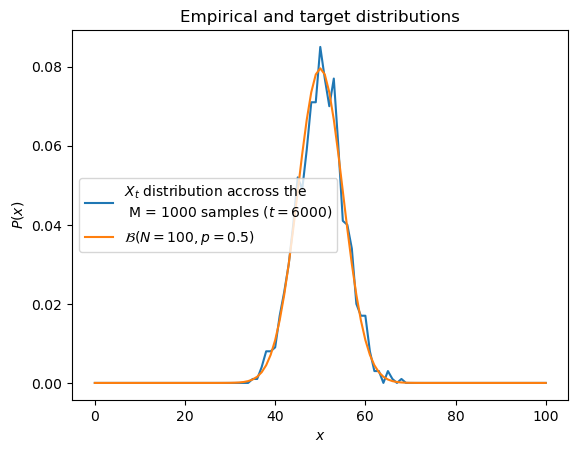

In [16]:
# function to create the distribution over the 1000 instances for a choosen time point

def empirical_t(t):

    counts, edges = np.histogram(instances[:,t], bins=np.arange(N+2))  # N+2 to cover values from 0 to N
    empirical = counts/M + 1e-10            # adding a small value to avoid log(0) when computing the KL divergence
    empirical = empirical / empirical.sum() # normalising again

    return empirical

# choosing which time t to use to create the distribution of the X_t over the 1000 instances
time = 6000

plt.figure()
plt.plot(x_val, empirical_t(time), label=f'$X_t$ distribution accross the \n M = 1000 samples ($t={time}$)')
plt.plot(x_val, target_distribution_1, label='$\mathcal{B}(N=100,p=0.5)$')

plt.xlabel('$x$')
plt.ylabel('$P(x)$')

plt.title('Empirical and target distributions')
plt.legend()
plt.show()

- Plot the Kullback-Leibler divergence between the target distribution $P_X(x)$ and the empirical distribution of the $M = 1000$ samples as a function of the time $t$.


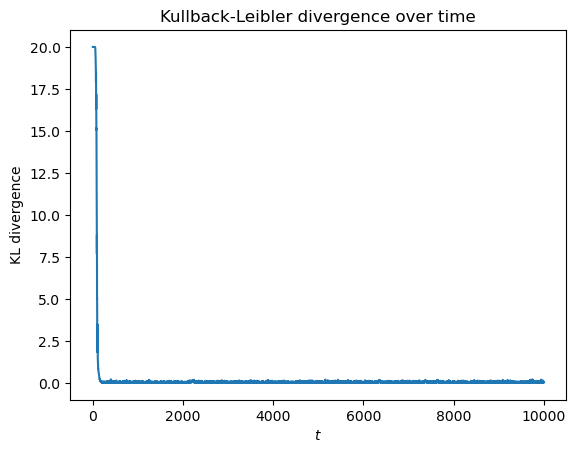

In [7]:
KL_t = [] # list to store the KL divergence computed for each t, each time over the 1000 samples

for j in range(0, tf+1):
    # for each t, we compute the KL divergence over the 1000 instances

    KL=0
    empiricalcounts = empirical_t(j)

    for i in range(len(x_val)):  
        KL += target_distribution_1[i]*np.log(target_distribution_1[i]/empiricalcounts[i]) # had to match the bins of the distribution to the length of x_val
                                                                                           # to be able to compute the KL index by index (so not really over the 1000 instances)
    KL_t.append(KL)

plt.figure()
plt.plot(np.arange(0, tf+1), KL_t)
plt.xlabel('$t$')
plt.ylabel('KL divergence')
plt.title('Kullback-Leibler divergence over time')
plt.show()

- Plot the correlation between $X_t$ and $X_{t+\tau}$ as a function of $\tau$ for large $t$ ($t = 1000$).

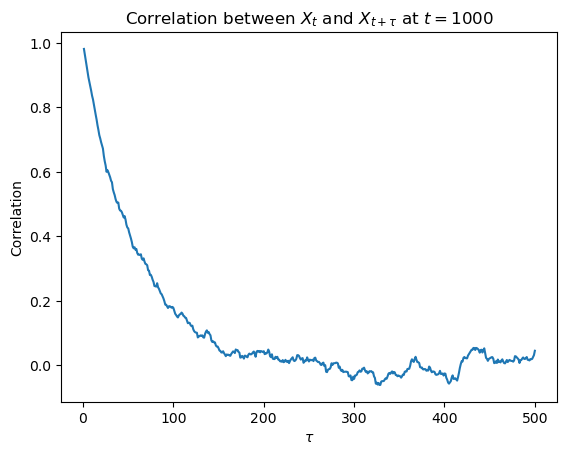

In [8]:
tau = np.arange(1, 501)

listcorr=[]

for j in tau:
    # computing the correlation between Xt and Xt+tau (t fixed), for each tau from 1 to 500 and storing that in a list
    corr = np.corrcoef(instances[:,1000],instances[:,1000+j])[0, 1]
    listcorr.append(corr)

plt.figure()
plt.plot(tau, listcorr)
plt.xlabel('$\\tau$')
plt.ylabel('Correlation')
plt.title('Correlation between $X_t$ and $X_{t+\\tau}$ at $t=1000$')
plt.show()

---

## Part 2

Let $X \in \mathbb{R}^2$ be a normally distributed variable,
$$X \sim \mathcal{N}(0,\overline{\Sigma})$$
with covariance matrix
$$\overline{\Sigma} = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$$
i.e., with PDF
$$f_X(x) = \frac{1}{2\pi\sqrt{\det\overline{\Sigma}}} e^{-\frac{1}{2}x^T\overline{\Sigma}^{-1}x}$$

Sample this distribution with the Metropolis algorithm.



In [9]:
# defining the covariance matrix, its inverse and its determinant 
cov_matrix = [[1, 0.8],[0.8, 1]]
inverse_covm = np.linalg.inv(cov_matrix)
det_covm = np.linalg.det(cov_matrix)

# Probability density function used for Part 2 ;
def PDF2(x):
    x = np.asarray(x).reshape(-1, 1)  # to force column vector (2, 1)
                                      # x^T Σ^{-1} x → (1, 2) @ (2, 2) @ (2, 1) = scalar
    
    quad_form = (x.T @ inverse_covm @ x)[0, 0]  # extracting the scalar

    return (1/(2*np.pi*np.sqrt(det_covm))) * np.exp(-0.5 * quad_form)



- Use the following symmetric transition rule
$$T(x', x) = \mathcal{N}(x, \Sigma_0), \qquad \Sigma_0 = \begin{pmatrix} 0.1 & 0 \\ 0 & 0.1 \end{pmatrix}$$
such that $x$ transitions to $x'$ that is normally distributed around $x$ with isotropic variance 0.1.


In [10]:
cov0 = 0.1*np.identity(2) # the Sigma0 matrix

def proposal2(x):
    # returning a proposal for the new state based on this symmetric transition rule
    return np.random.multivariate_normal(x, cov0)

Combine the transition matrix (proposal) $T(x', x)$ with the Metropolis acceptance rule
$$A(x', x) = \min\left\{1, \frac{f_X(x')}{f_X(x)}\right\}$$
to define a Monte Carlo Markov Chain.

In [ ]:
def acceptance2(x, xp):
    r = PDF2(xp)/PDF2(x) # computing the ratio 
    # if r >= 1 the new state is better
    # if r < 1  the new state is worse

    # choosing the minimum between 1 and the ratio (in order to always have a proba not greater than 1)
    m = min(1, r) 
    # if r >= 1, m = 1 
    # if r < 1,  m = r

    # random number in [0, 1) from the uniform distribution
    sample = np.random.rand()

    return sample < m # true we accept the new state, false we don't 

    # if r >= 1, m = 1, we always have sample < m, we return true (automatically accepted)
    # if r < 1,  m = r, we return true when sample < r, i.e. we accept the the new state with probability r

# the Monte Carlo Markov Chain using the symmetric transition rule and the acceptance rule defined previously :
def chain2(x):

    # proposing the new state
    xp = proposal2(x)

    # accepting the new state or keeping the previous one
    if acceptance2(x, xp):
        return xp
    else: 
        return x



- Start from $X_0 = (3, 3)$ and let the Markov chain evolve, $X_t \rightarrow X_{t+1}$ up to $t = 10000$. Repeat this $M = 1000$ times, so that you have $M = 1000$ instances of the chain (for each value of $t$ you have $M = 1000$ values of $X_t$).


In [12]:
# initial and final times
t0 = 0
tf = 10000

# number of instances of the chain
M = 1000

# list to store each of the instances
instances2=[]


# using libraries to compute in parallel to speed up a bit the computation (probably even faster with Numba)
from joblib import Parallel, delayed

# function to let the Markov chain evolve and create an instance of it, from initial time t0 to final time tf
def run_single_chain2():

    X = [np.array([3.0, 3.0])] # current instance starting with the state first X0 =(3,3)

    # the chain evolves from time t = 0 to t = 10000
    for t in range(tf):
        X.append(chain2(X[t])) # adding the new state to the current instance

    return np.array(X) # returning the instance (the chain)

# Parallelisation (using n_jobs = 8 to match the number of my CPU cores) :
# Running in parallel 1000 times the function defined previously to fill the instances2 list with 1000 instances of the chain
instances2 = Parallel(n_jobs=8, backend='loky', verbose=10, batch_size='auto')(
    delayed(run_single_chain2)() for _ in tqdm(range(0,M), desc="Part 2 : Running chains"))

instances2 = np.array(instances2)

Part 2 : Running chains:   2%|▏         | 16/1000 [00:01<01:35, 10.33it/s][Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.1s
Part 2 : Running chains: 100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  2.0min finished




- Check that $X_t$ (across the $M = 1000$ samples) is distributed according to the target distribution, $X_t \sim \mathcal{N}(0,\overline{\Sigma})$ for $t \gtrsim 200$.

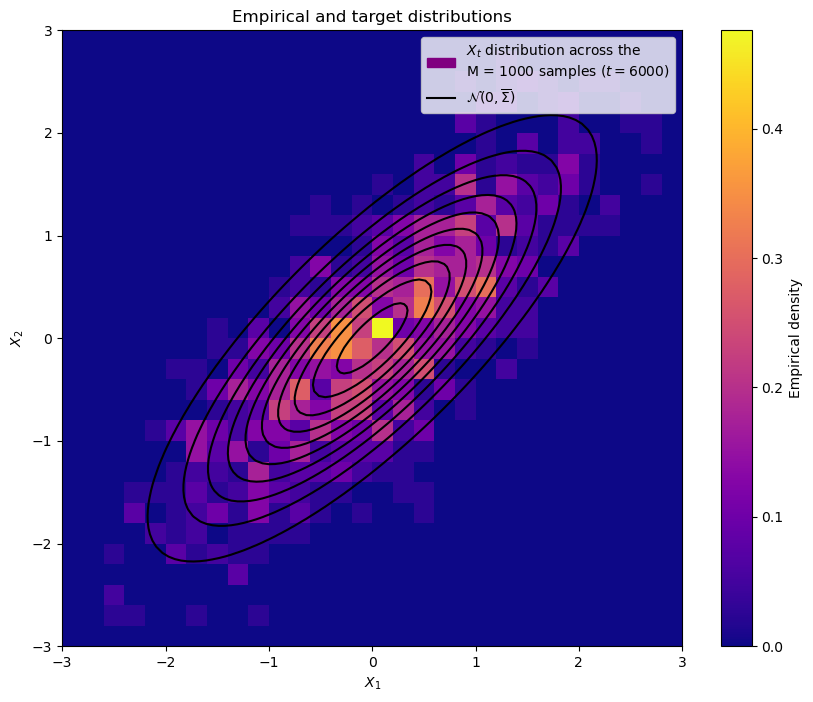

In [ ]:
# choosing which time t to use to create the distribution of the X_t over the 1000 instances
t = 6000

# selecting Xt over the M samples (2 coordinates for one Xt)
x1_samples = instances2[:, t, 0]
x2_samples = instances2[:, t, 1]

plt.figure(figsize=(10, 8))

plt.hist2d(x1_samples, x2_samples, bins=30, range=[[-3, 3], [-3, 3]], cmap='plasma', density=True)
plt.colorbar(label='Empirical density')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Empirical and target distributions')

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z_target = np.array([PDF2([x, y]) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
plt.contour(X, Y, Z_target, levels=10, colors='black', linewidths=1.5)

# legend of the plot
hist_patch = mpatches.Patch(color='purple', label=f'$X_t$ distribution across the\nM = 1000 samples ($t={t}$)')
contour_line = plt.Line2D([0], [0], color='black', linewidth=1.5, label=r'$\mathcal{N}(0,\overline{\Sigma})$')
plt.legend(handles=[hist_patch, contour_line])

plt.show()


- Plot the Kullback-Leibler divergence between the target distribution $P_X(x)$ and the empirical distribution of the $M = 1000$ samples as a function of the time $t$.

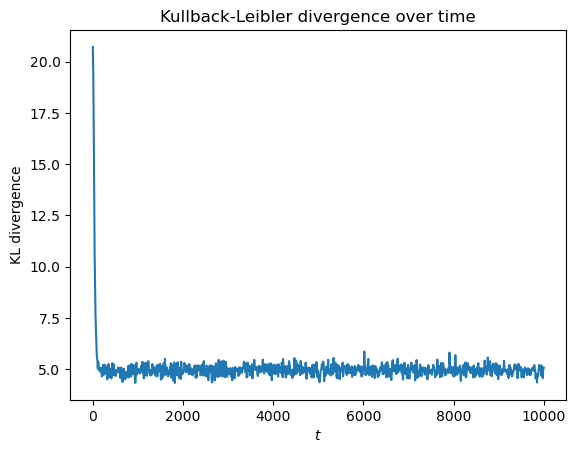

In [14]:
KL_t = [] # list to store the KL divergence computed for each t, each time over the 1000 samples

# setting up the 2D histogram grid
bins = 50
x_edges = np.linspace(-3, 3, bins + 1)
y_edges = np.linspace(-3, 3, bins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
Xc, Yc = np.meshgrid(x_centers, y_centers)

# for each t, we compute the KL divergence over the 1000 instances
for t in range(0, tf+1, 10):  # every 10 steps to speed up
    x1 = instances2[:, t, 0]
    x2 = instances2[:, t, 1]

    # computing the empirical 2D histogram
    H, _, _ = np.histogram2d(x1, x2, bins=[x_edges, y_edges], density=True)
    H = H + 1e-10       # adding a small value to avoid log(0)
    H = H / H.sum()     # normalising

    # Target PDF on grid
    Z_target = np.array([PDF2([x, y]) for x, y in zip(Xc.flatten(), Yc.flatten())]).reshape(H.shape)
    Z_target = Z_target + 1e-10
    Z_target = Z_target / Z_target.sum()

    # KL divergence
    KL = np.sum(Z_target * np.log(Z_target / H))
    KL_t.append(KL)

plt.plot(np.arange(0, tf+1, 10), KL_t)
plt.xlabel('$t$')
plt.ylabel('KL divergence')
plt.title('Kullback-Leibler divergence over time')
plt.show()



- Plot the correlation between $X_t$ and $X_{t+\tau}$ as a function of $\tau$ for large $t$ ($t = 1000$).

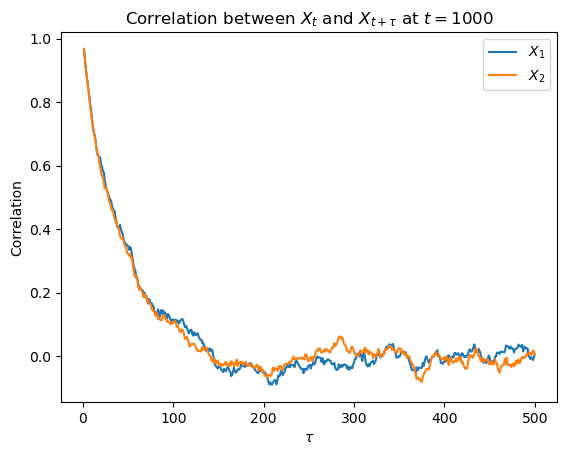

In [15]:
tau = np.arange(1, 501)
corrs_x1 = []
corrs_x2 = []

for j in tau:

    # computing the correlation between Xt_1 and Xt_1 + tau (t fixed), for each tau from 1 to 500 and storing that in a list
    corr_x1 = np.corrcoef(instances2[:, 1000, 0], instances2[:, 1000 + j, 0])[0, 1]
    corrs_x1.append(corr_x1)

    # computing the correlation between Xt_2 and Xt_2 + tau (t fixed), for each tau from 1 to 500 and storing that in a list
    corr_x2 = np.corrcoef(instances2[:, 1000, 1], instances2[:, 1000 + j, 1])[0, 1]
    corrs_x2.append(corr_x2)

plt.plot(tau, corrs_x1, label='$X_{1}$')
plt.plot(tau, corrs_x2, label='$X_{2}$')
plt.xlabel('$\\tau$')
plt.ylabel('Correlation')

plt.title('Correlation between $X_t$ and $X_{t+\\tau}$ at $t=1000$')
plt.legend()
plt.show()